In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [2]:
# Install spark-related depdencies for Python
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 217.8MB 54kB/s 
     |████████████████████████████████| 204kB 44.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=c1bb4a30c35216f36e0d1e55c3751ad82dc8df9317c7dc7bb61aed38175c47b9
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [4]:
# Point Colaboratory to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [0]:

# we use a set of constants for clarity and simplicity in managing the notebook.
# this allows you to refer back to this cell at any time if you need to either confirm or modify any of these values.

DATA_NAME = "/content/gdrive/My Drive/Colab Datasets/AmazonInstantVideo.json"
APP_NAME = "Sentiment Analysis with Amazon Reviews Exercise"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 4
RF_NUM_BINS = 32

In [0]:
sc = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sqlContext = SQLContext(sc)

In [0]:
amznInstantVideo = sqlContext.read.json(DATA_NAME)

In [21]:
print(f"Dataset shape is {amznInstantVideo.count():d} rows by {len(amznInstantVideo.columns):d} columns.")


Dataset shape is 37126 rows by 9 columns.


In [22]:
amznInstantVideo.printSchema()


root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [0]:
amznInstantVideo.registerTempTable('reviews')


In [24]:
sqlContext.sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc").show()


+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|      20890|
|    4.0|       8446|
|    3.0|       4187|
|    2.0|       1885|
|    1.0|       1718|
+-------+-----------+



In [0]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())

amznInstantVideo = amznInstantVideo.withColumn("overall_recode",udf(amznInstantVideo.overall))

([<matplotlib.axis.XTick at 0x7fc8bbea29e8>,
 [Text(0, 0, '-1'), Text(0, 0, '1')])

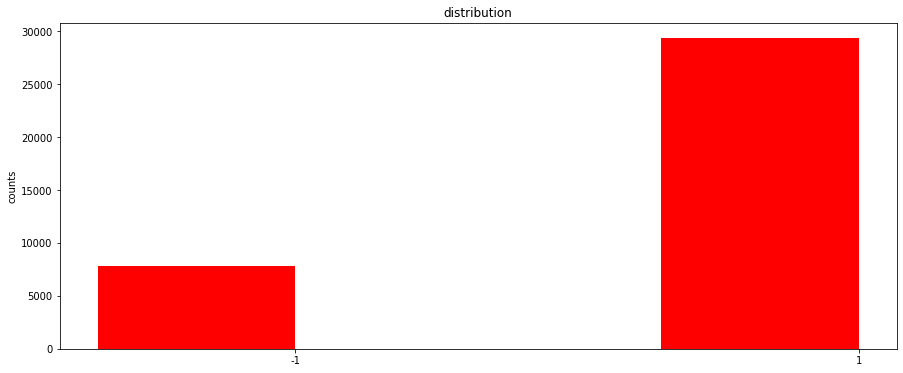

In [26]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = amznInstantVideo.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind + width/2., categories)

In [27]:
amznInstantVideo.select("overall", "overall_recode", "summary", "reviewText").show(10)


+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    2.0|            -1|A little bit bori...|I had big expecta...|
|    5.0|             1|Excellent Grown U...|I highly recommen...|
|    1.0|            -1|Way too boring fo...|This one is a rea...|
|    4.0|             1|Robson Green is m...|Mysteries are int...|
|    5.0|             1|Robson green and ...|This show always ...|
|    5.0|             1|I purchased the s...|I discovered this...|
|    3.0|            -1|It takes up your ...|It beats watching...|
|    3.0|            -1|A reasonable way ...|There are many ep...|
|    5.0|             1|           kansas001|This is the best ...|
|    3.0|            -1| Entertaining Comedy|Not bad.  Didn't ...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [0]:
from pyspark import SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.ml.feature import CountVectorizer
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokenized_text").transform(amznInstantVideo)
# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="tokenized_text", outputCol="Features", vocabSize=20)

model = cv.fit(tokenizer)

cv_result = model.transform(tokenizer)

In [0]:
word2Vec = Word2Vec(vectorSize=300, seed=42, inputCol="tokenized_text", outputCol="w2v_vector").fit(tokenizer)

w2vdf=word2Vec.transform(tokenizer)


In [43]:
cv_result.select("overall_recode", "reviewText", "tokenized_text","Features").show(10)


+--------------+--------------------+--------------------+--------------------+
|overall_recode|          reviewText|      tokenized_text|            Features|
+--------------+--------------------+--------------------+--------------------+
|            -1|I had big expecta...|[i, had, big, exp...|(20,[1,3,5,7,8,9,...|
|             1|I highly recommen...|[i, highly, recom...|(20,[1,2,3,5,7,8,...|
|            -1|This one is a rea...|[this, one, is, a...|(20,[0,2,5,7,8,19...|
|             1|Mysteries are int...|[mysteries, are, ...|(20,[0,1,5,6,14,1...|
|             1|This show always ...|[this, show, alwa...|(20,[0,1,2,3,4,5,...|
|             1|I discovered this...|[i, discovered, t...|(20,[0,1,2,3,4,5,...|
|            -1|It beats watching...|[it, beats, watch...|(20,[2,3,4,7,9,10...|
|            -1|There are many ep...|[there, are, many...|(20,[2,3,4,6,7,8,...|
|             1|This is the best ...|[this, is, the, b...|(20,[0,2,3,4,5,7,...|
|            -1|Not bad.  Didn't ...|[no

In [0]:

# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(cv_result)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="Features", outputCol="indexedFeatures", maxCategories=4).fit(cv_result)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = cv_result.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [0]:

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [46]:

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.212077
Accuracy = 0.787923
